## Import SEG_SGEMM Data as int64 

In [39]:
import tensorflow as tf
from tensorflow import keras

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

original = np.genfromtxt("./로그 데이터/SEG_SGEMM_result.txt", delimiter="\n", dtype=np.int64).reshape(-1, 1)
original = pd.DataFrame(data=original, columns=["SEG"])
original

,SEG
0,3196231680
1,93292771632
2,93293300344
3,93293373376
4,93292057424
...,...
237191,92622695528
237192,92622695520
237193,92658792872
237194,92658792864


In [41]:
split_index = 200000
data = original.copy()
train_set = data[:split_index]
test_set = data[split_index:]
test_set.reset_index(drop=True, inplace=True)
train_set, test_set

(                SEG
 0        3196231680
 1       93292771632
 2       93293300344
 3       93293373376
 4       93292057424
 ...             ...
 199995  93237490240
 199996  93230418624
 199997  93250149116
 199998  93249799072
 199999  93250795088
 
 [200000 rows x 1 columns],
                SEG
 0      93294595904
 1      93250622624
 2      93294603856
 3      93294597824
 4      93239913184
 ...            ...
 37191  92622695528
 37192  92622695520
 37193  92658792872
 37194  92658792864
 37195  92654987192
 
 [37196 rows x 1 columns])

In [42]:
def delta_slice(data, step, cutoff=None):
    if cutoff:
        data = data[cutoff:].reset_index(drop=True)
    delta = pd.DataFrame(data=[data.loc[i+step] - data.loc[i] for i in range(int(len(data)/step))])
    return delta

In [43]:
step = 4

train_delta = delta_slice(train_set, step)
train_delta

,SEG
0,90095825744
1,-554048
2,-533664
3,-1423712
4,140816
...,...
49995,209608992
49996,-578542672
49997,-218508876
49998,1641488


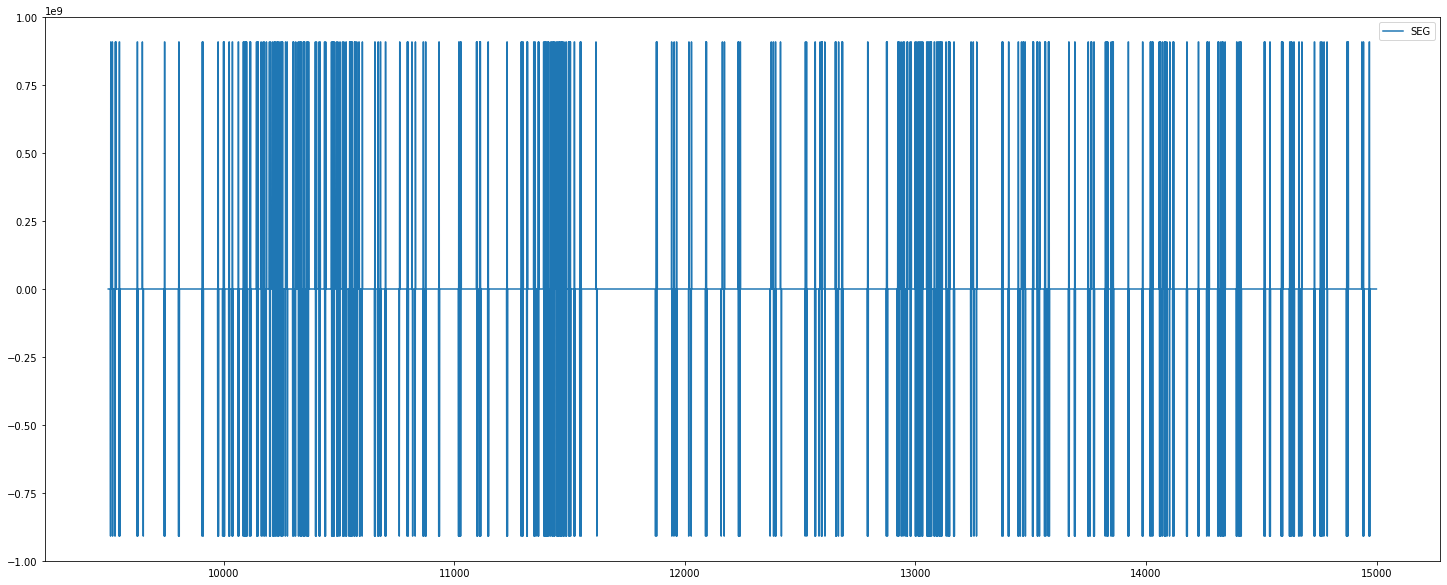

In [71]:
train_delta[9500:15000].plot(figsize=(25, 10))

In [77]:
delta_counts = train_delta["SEG"].value_counts()
delta_counts

-1            25144
 0            23866
 909517620      437
-909517620      434
 16384          119
Name: SEG, dtype: int64

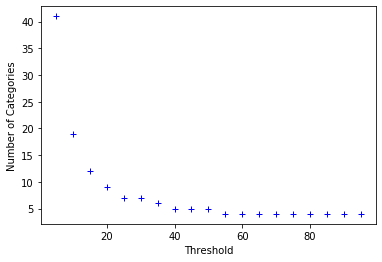

In [45]:
data_over_threshold_incremental = pd.DataFrame(data=[(delta_counts > i*5).value_counts().values for i in range(1, 20)], columns=["Under Threshold", "Over Threshold"])
plt.plot([i*5 for i in range(1, 20)], data_over_threshold_incremental["Over Threshold"], "b+")
plt.xlabel("Threshold")
plt.ylabel("Number of Categories")
plt.show()

In [46]:
threshold_num_of_delta = 100
delta_counts_over_threshold = (delta_counts > threshold_num_of_delta)
delta_counts_over_threshold.value_counts()

False    22899
True         4
Name: SEG, dtype: int64

In [47]:
categories_over_threshold = delta_counts_over_threshold.index[delta_counts_over_threshold == True]
categories_over_threshold

Int64Index([0, 909517620, -909517620, 16384], dtype='int64')

In [48]:
num_data_in_categories = train_delta["SEG"].isin(categories_over_threshold).value_counts()
data_over_threshold_ratio = num_data_in_categories.values[0] / (num_data_in_categories.values[0] + num_data_in_categories.values[1])
data_over_threshold_ratio

0.50288

In [49]:
train_delta_mapped = train_delta["SEG"].isin(categories_over_threshold)
train_delta_mapped_index = train_delta_mapped.index[train_delta_mapped == False]
train_delta_mapped_index

Int64Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,
                9,
            ...
            49990, 49991, 49992, 49993, 49994, 49995, 49996, 49997, 49998,
            49999],
           dtype='int64', length=25144)

In [50]:
train_delta.loc[train_delta_mapped_index] = -1
train_delta["SEG"].value_counts()

-1            25144
 0            23866
 909517620      437
-909517620      434
 16384          119
Name: SEG, dtype: int64

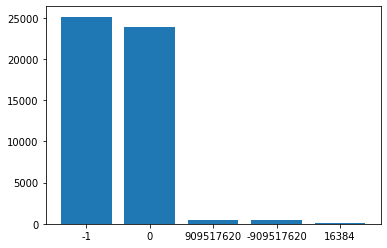

In [51]:
train_delta_counted = train_delta["SEG"].value_counts()
plt.bar(train_delta_counted.index.map(str), train_delta_counted.values)
plt.show()

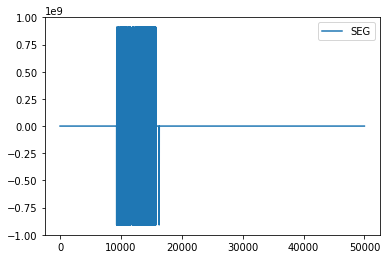

In [66]:
train_delta.plot()

In [52]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i)
        # Reshape data from (history_size,) to (history_size, 1)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i+target_size])
    return np.array(data), np.array(labels)

In [53]:
PAST_HISTORY = 1
FUTURE_TARGET = 1
TRAIN_VAL_SPLIT = 40000

x_train, y_train = univariate_data(train_delta.values, 0, TRAIN_VAL_SPLIT, PAST_HISTORY, FUTURE_TARGET)
x_val, y_val = univariate_data(train_delta.values, TRAIN_VAL_SPLIT, None, PAST_HISTORY, FUTURE_TARGET)

In [54]:
BATCH_SIZE = 256
BUFFER_SIZE = 100000

train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_data = val_data.cache().batch(BATCH_SIZE).repeat()

In [72]:
num_neuron_1 = 64
num_neuron_2 = 32
EPOCHS = 50

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(num_neuron_1, return_sequences=True, input_shape=x_train.shape[-2:]))
model.add(tf.keras.layers.LSTM(num_neuron_2, activation='relu'))
model.add(tf.keras.layers.Dense(1))
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss="categorical_crossentropy", metrics=['accuracy'])

In [73]:
model_history = model.fit(train_data, epochs=EPOCHS, steps_per_epoch=200, validation_data=val_data, validation_steps=200)

Epoch 1/50
200/200 [==============================] - 2s 8ms/step - loss: 4.1319e-06 - accuracy: 0.5972 - val_loss: 6.9140e-06 - val_accuracy: 9.0018e-04
Epoch 2/50
200/200 [==============================] - 1s 7ms/step - loss: 0.0043 - accuracy: 0.5965 - val_loss: 6.9140e-06 - val_accuracy: 9.0018e-04
Epoch 3/50
200/200 [==============================] - 1s 7ms/step - loss: 0.0213 - accuracy: 0.5966 - val_loss: 6.9140e-06 - val_accuracy: 9.0018e-04
Epoch 4/50
200/200 [==============================] - 1s 7ms/step - loss: 0.0128 - accuracy: 0.5948 - val_loss: 6.9140e-06 - val_accuracy: 9.0018e-04
Epoch 5/50
200/200 [==============================] - 1s 7ms/step - loss: 0.0255 - accuracy: 0.5968 - val_loss: 6.9140e-06 - val_accuracy: 9.0018e-04
Epoch 6/50
200/200 [==============================] - 1s 7ms/step - loss: -0.0191 - accuracy: 0.5965 - val_loss: 6.9140e-06 - val_accuracy: 9.0018e-04
Epoch 7/50
200/200 [==============================] - 1s 7ms/step - loss: -0.0064 - accuracy: 0

In [60]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])
    plt.show()

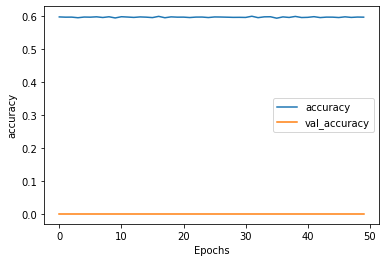

In [74]:
plot_graphs(model_history, 'accuracy')

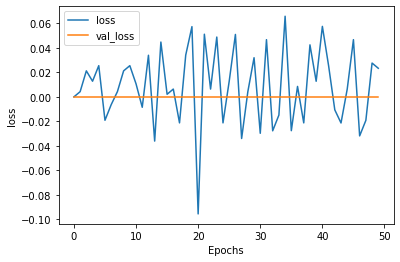

In [75]:
plot_graphs(model_history, 'loss')